In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import math


# Importing the dataset

In [2]:
polish_data = pd.read_csv(r"C:\Users\chris\OneDrive\MSc\Kalman Filter - Polish Paper\polish_data.csv")
print(polish_data.head())

   time  delta_time        X        Y  rot  Vmps  rot_sec
0     0           0  6062445  4368335  3.8   5.2     0.13
1    11          11  6062500  4368343  5.1   5.2     0.12
2    20           9  6062556  4368351  6.3   5.2    -0.10
3    29           9  6062600  4368359  5.3   5.4     0.35
4    39          10  6062655  4368367  8.8   5.3    -0.12


## Adding onbservations at each index $\Delta t = 1$

In [3]:
#Get the last time index
last_time = polish_data.iloc[-1][0]
upper_time = int(math.ceil(last_time / 10.0)) * 10 #rounding to nearest 10
upper_time

time_temp = np.arange(0,upper_time,1)


insert_blank = pd.DataFrame({'time': 0,"delta_time":0,"X":0,"Y":0, "rot":0, "Vmps":0, "rot_sec":0}, index = [0])
new_polish_dat =  pd.DataFrame({'time': 0,"delta_time":0,"X":0,"Y":0, "rot":0, "Vmps":0, "rot_sec":0}, index = [0])

k=0

for i in time_temp:
    insert_blank = pd.DataFrame({'time': i,"delta_time":0,"X":0,"Y":0, "rot":0, "Vmps":0, "rot_sec":0}, index = [0])
    if(time_temp[i] !=  int(polish_data.iloc[k][0])):
        new_polish_dat =pd.concat([new_polish_dat, insert_blank])
    else:
        new_polish_dat = pd.concat([new_polish_dat, pd.DataFrame.transpose(pd.DataFrame(polish_data.iloc[k]))])
        k += 1
        

In [4]:
pd.DataFrame.transpose(pd.DataFrame(polish_data.iloc[0]))

,time,delta_time,X,Y,rot,Vmps,rot_sec
0,0.0,0.0,6062445.0,4368335.0,3.8,5.2,0.13


In [5]:
new_kalman_data = new_polish_dat
#new_kalman_data

## Conversion functions:

In [6]:
def deg_to_rad(deg):
    return deg*np.pi/180

def rad_to_deg(rad):
    return rad*180/np.pi

def rot_min_to_sec(rot_min):
    return rot_min/60

def knots_to_mps(kts):
    return kts*0.51444444

In [7]:
def get_state_vector_Xk(data_frame, stateNo):

    #X coordinate    
    X_coord = data_frame.iloc[stateNo,2]

    #Y coordinate
    Y_coord = data_frame.iloc[stateNo,3]

    #Vk - speed over ground
    sog = data_frame.iloc[stateNo,5]
    
    #Course over ground
    cog = data_frame.iloc[stateNo,4]

    
    #retunr state
    X_k = np.array([
            [X_coord],
           [Y_coord],
           [sog*np.cos(deg_to_rad(cog))], 
           [sog*np.sin(deg_to_rad(cog))]])
    return X_k
    

## Formulas fo the excelleration in the X and Y axis:

In [8]:
def calc_a_x_y(data_frame, stateNo, deltaTime):
    
    #Vk - speed over ground metre per second
    sog = data_frame.iloc[stateNo,5]
    
    #Course over ground - current state 
    cog = data_frame.iloc[stateNo,4]
    
    #Course over ground - previous state 
    cog_prev = data_frame.iloc[stateNo-1,4]
    
    #Rate of turn - degrees per second
    rot = data_frame.iloc[stateNo,4]
    
    top_x = sog*np.cos(deg_to_rad(cog) + deg_to_rad(rot)*deltaTime) - np.cos(deg_to_rad(cog_prev))
    bottom_x = deltaTime
    
    a_x = top_x/bottom_x
    
    top_y = sog*np.sin(deg_to_rad(cog) + deg_to_rad(rot)*deltaTime) - np.sin(deg_to_rad(cog_prev))
    bottom_y = deltaTime
    
    a_y = top_y/bottom_y
    
    return a_x, a_y


In [9]:
def get_mat_A():
    A = np.identity(4)
    A[0,2] = 1
    A[1,3] = 1
    return A

A = get_mat_A()
A

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [10]:
def est_coord_X_Y(a_x, a_y, prev_X, prev_Y, deltaTime):
    X_k = prev_X + a_x*deltaTime*deltaTime/2
    Y_k = prev_Y + a_y*detlaTime*deltaTime/2
    
    return X_k, Y_k

In [11]:
def predict_state(A,X_prev, a_x,a_y, w_k):
    Bu_k = np.array([[a_x*0.5],
                     [a_y*0.5],
                     [a_x],
                     [a_y]])
    
    pred_state = A.dot(X_prev) + Bu_k + w_k
    return pred_state

### Getting the state vector if we are only predicting:

In [12]:
def get_state_vector_Xk_finalDF(data_frame, stateNo):

    #X coordinate    
    X_coord = data_frame.iloc[stateNo,0]

    #Y coordinate
    Y_coord = data_frame.iloc[stateNo,1]

    #Vk - speed over ground
    sog = data_frame.iloc[stateNo,2]
    
    #Course over ground
    cog = data_frame.iloc[stateNo,3]

    
    #retunr state
    X_k = np.array([
            [X_coord],
           [Y_coord],
           [sog*np.cos(deg_to_rad(cog))], 
           [sog*np.sin(deg_to_rad(cog))]])
    return X_k

## Predicting the Proccess error covariance $P_{k}^{-}$ :

In [13]:
def pred_err_cov(A, P_k_1,Q):
    return A.dot(P_k_1).dot(np.transpose(A)) + Q

## Kalman gain $K_k$ :

In [14]:
def Kalman_gain(P_k, H, R):
    above = P_k.dot(np.transpose(H))
    bottom = np.linalg.inv(H.dot(P_k).dot(np.transpose(H)) + R)
    return above.dot(bottom)

## A posteriori estimate $\hat{x}_k$ :

In [15]:
def adjust_pred_state(pred_state, Kk,z_k,H):
    #Where z_k == the real observed value to adjust for the errors made
    return pred_state + Kk.dot(z_k - H.dot(pred_state))

## Update proccess error cov $P_k$

In [16]:
def adjust_err_cov(I,Kk,H,P_k):
    return (I - Kk.dot(H)).dot(P_k)    

## Getting the length of the dataset

In [17]:
data_length = len(new_kalman_data)

# Linear algo's

In [26]:
def delta_X_Y_pred(state_in, a_x, a_y):
    delta_x_k = state_in[0] + a_x*0.5
    delta_y_k = state_in[1] + a_y*0.5
    
    return delta_x_k, delta_y_k

# Setting up prediction & Kalman filtering:

In [39]:
# Setting up a prediction dataFrame
df_final = pd.DataFrame()
df_final.drop(df_final.index, inplace=True) #Clear DataFRAME
df_final = pd.DataFrame({"X_pred":0,"Y_pred":0, "Lin_spd_X":0, "Lin_spd_Y":0}, index = [0])
df_final


#Appending the first values to the dataframe
my_State_Vec = get_state_vector_Xk(new_kalman_data,1)
df_final = df_final.append(pd.DataFrame({"X_pred":my_State_Vec[0],
                                         "Y_pred":my_State_Vec[1],
                                         "Lin_spd_X":my_State_Vec[2],
                                         "Lin_spd_Y":my_State_Vec[3]}, index = [1]))


# Array for the 1st and second coordinates
x_pred = []
y_pred = []

#Initial P_{k-1}
Pk_1 =  np.array([[10],[10],[0.5],[0.5]]).dot(np.transpose(np.array([[10],[10],[0.5],[0.5]]))) #according to the IMO
H = np.identity(4)
R = np.diag(np.diag(Pk_1))
I = np.identity(4)



#------------------------------------------Setting up the KALMAN VARIABLES --------------------------------------
A = get_mat_A()
w_k_1 = np.array([[0],[0],[0],[0]])
P_k =  np.array([[10],[10],[0.5],[0.5]]).dot(np.transpose(np.array([[10],[10],[0.5],[0.5]]))) #according to the IMO.
Q = P_k
H = np.identity(4)
R = np.diag(np.diag(Pk_1))
I = np.identity(4)
#------------------------------------------END KALMAN VARIABLES --------------------------------------





for i in range(1,data_length):
    
    #If we have the real value do this:
    if(int(new_kalman_data.iloc[i,3]) != 0):
        #If we have the value, we will need to do a prediction with a correction
        
       # print(new_kalman_data.iloc[i,:])
        
        if(i == 1):
            state_vector = get_state_vector_Xk(new_kalman_data, i)
            a_x, a_y = calc_a_x_y(new_kalman_data,i,1)
            #predict_state(A,X_prev, a_x,a_y, w_k):
            predicted_State = predict_state(A,state_vector,a_x, a_y, w_k_1)
            P_k =  pred_err_cov(A,P_k,Q)
            
            w_k_1 = state_vector - predicted_State
            Q = P_k
            
            #---------------------------- UPDATE -------------------------:
            # Kalman Gain
            K_k = Kalman_gain(P_k, H, R)         
            # a posteriori estimate
            x_k = adjust_pred_state(predicted_State, K_k,state_vector,H)
            # proccess covariance update
            P_k = adjust_err_cov(I,K_k,H,P_k)
            
                        # Kalman Gain
            K_k = Kalman_gain(P_k, H, R)         
            # a posteriori estimate
            x_k = adjust_pred_state(predicted_State, K_k,state_vector,H)
            # proccess covariance update
            P_k = adjust_err_cov(I,K_k,H,P_k)

         
            df_final = df_final.append(pd.DataFrame({"X_pred":predicted_State[0],
                                         "Y_pred":predicted_State[1],
                                         "Lin_spd_X":predicted_State[2],
                                         "Lin_spd_Y":predicted_State[3]}, index = [1]))
    
        else:
            # We want to update the filter estiamtes
            
            #---------------------------- PREDICTION --------------------:
            state_vector = get_state_vector_Xk(new_kalman_data, i)
            a_x, a_y = calc_a_x_y(new_kalman_data,i,1) 
            predicted_State = predict_state(A,state_vector,a_x, a_y, w_k_1)
            
            w_k_1 = state_vector - predicted_State
            Q = P_k
            P_k =  pred_err_cov(A,P_k,Q)
            
            #---------------------------- UPDATE -------------------------:
            # Kalman Gain
            K_k = Kalman_gain(P_k, H, R)         
            # a posteriori estimate
            x_k = adjust_pred_state(predicted_State, K_k,state_vector,H)
            # proccess covariance update
            P_k = adjust_err_cov(I,K_k,H,P_k)
                        
            df_final = df_final.append(pd.DataFrame({"X_pred":x_k[0],
                                         "Y_pred":x_k[1],
                                         "Lin_spd_X":x_k[2],
                                         "Lin_spd_Y":x_k[3]}, index = [1]))
        print("Have Value")
        print(i," a_x: ", a_x) 
        print(i," a_y: ", a_y)
        print(i," pred state: ",predicted_State[0])
        print()
    else:
        #If we do not have the value, just predict a state ahead and append to dataset
        state_vector = get_state_vector_Xk_finalDF(df_final, i)

        predicted_State = predict_state(A,state_vector,a_x, a_y, w_k_1)

        df_final = df_final.append(pd.DataFrame({"X_pred":predicted_State[0],
                                         "Y_pred":predicted_State[1],
                                         "Lin_spd_X":predicted_State[2],
                                         "Lin_spd_Y":predicted_State[3]}, index = [1]))
        print("Predict Value")
        print(i," a_x: ", a_x)
        print(i," a_y: ", a_y)
        print(i," pred state: ",predicted_State[0])
        print()



Have Value
1  a_x:  4.154320809308017
1  a_y:  0.6877332293370367
1  pred state:  [6062452.26572804]

Predict Value
2  a_x:  4.154320809308017
2  a_y:  0.6877332293370367
2  pred state:  [6062456.41853231]

Predict Value
3  a_x:  4.154320809308017
3  a_y:  0.6877332293370367
3  pred state:  [6062460.57129626]

Predict Value
4  a_x:  4.154320809308017
4  a_y:  0.6877332293370367
4  pred state:  [6062464.72405914]

Predict Value
5  a_x:  4.154320809308017
5  a_y:  0.6877332293370367
5  pred state:  [6062468.87682199]

Predict Value
6  a_x:  4.154320809308017
6  a_y:  0.6877332293370367
6  pred state:  [6062473.02958485]

Predict Value
7  a_x:  4.154320809308017
7  a_y:  0.6877332293370367
7  pred state:  [6062477.1823477]

Predict Value
8  a_x:  4.154320809308017
8  a_y:  0.6877332293370367
8  pred state:  [6062481.33511055]

Predict Value
9  a_x:  4.154320809308017
9  a_y:  0.6877332293370367
9  pred state:  [6062485.48787341]

Predict Value
10  a_x:  4.154320809308017
10  a_y:  0.68773

Predict Value
84  a_x:  4.350267330151682
84  a_y:  1.2746134692178652
84  pred state:  [6063172.31446469]

Predict Value
85  a_x:  4.350267330151682
85  a_y:  1.2746134692178652
85  pred state:  [6063227.52843362]

Predict Value
86  a_x:  4.350267330151682
86  a_y:  1.2746134692178652
86  pred state:  [6063286.65872657]

Predict Value
87  a_x:  4.350267330151682
87  a_y:  1.2746134692178652
87  pred state:  [6063349.64919845]

Predict Value
88  a_x:  4.350267330151682
88  a_y:  1.2746134692178652
88  pred state:  [6063416.40023599]

Predict Value
89  a_x:  4.350267330151682
89  a_y:  1.2746134692178652
89  pred state:  [6063486.72749284]

Predict Value
90  a_x:  4.350267330151682
90  a_y:  1.2746134692178652
90  pred state:  [6063560.27554068]

Predict Value
91  a_x:  4.350267330151682
91  a_y:  1.2746134692178652
91  pred state:  [6063636.33510418]

Predict Value
92  a_x:  4.350267330151682
92  a_y:  1.2746134692178652
92  pred state:  [6063713.46719171]

Predict Value
93  a_x:  4.35

167  pred state:  [6063995.5440004]

Predict Value
168  a_x:  4.4191713546990385
168  a_y:  1.411588406161436
168  pred state:  [6064079.86091348]

Predict Value
169  a_x:  4.4191713546990385
169  a_y:  1.411588406161436
169  pred state:  [6064168.48398677]

Predict Value
170  a_x:  4.4191713546990385
170  a_y:  1.411588406161436
170  pred state:  [6064261.06750959]

Have Value
171  a_x:  4.2740303030045075
171  a_y:  1.1595707667021413
171  pred state:  [6063372.51828581]

Predict Value
172  a_x:  4.2740303030045075
172  a_y:  1.1595707667021413
172  pred state:  [6063372.52215743]

Predict Value
173  a_x:  4.2740303030045075
173  a_y:  1.1595707667021413
173  pred state:  [6063375.77570137]

Predict Value
174  a_x:  4.2740303030045075
174  a_y:  1.1595707667021413
174  pred state:  [6063378.90966463]

Predict Value
175  a_x:  4.2740303030045075
175  a_y:  1.1595707667021413
175  pred state:  [6063381.92394965]

Predict Value
176  a_x:  4.2740303030045075
176  a_y:  1.1595707667021413

Predict Value
248  a_x:  4.34744757120448
248  a_y:  0.7515347451843534
248  pred state:  [6063985.78552599]

Predict Value
249  a_x:  4.34744757120448
249  a_y:  0.7515347451843534
249  pred state:  [6064000.78686576]

Predict Value
250  a_x:  4.34744757120448
250  a_y:  0.7515347451843534
250  pred state:  [6064016.01927085]

Predict Value
251  a_x:  4.34744757120448
251  a_y:  0.7515347451843534
251  pred state:  [6064031.48237175]

Predict Value
252  a_x:  4.34744757120448
252  a_y:  0.7515347451843534
252  pred state:  [6064047.17579161]

Predict Value
253  a_x:  4.34744757120448
253  a_y:  0.7515347451843534
253  pred state:  [6064063.09914602]

Predict Value
254  a_x:  4.34744757120448
254  a_y:  0.7515347451843534
254  pred state:  [6064079.25204291]

Predict Value
255  a_x:  4.34744757120448
255  a_y:  0.7515347451843534
255  pred state:  [6064095.63408235]

Predict Value
256  a_x:  4.34744757120448
256  a_y:  0.7515347451843534
256  pred state:  [6064112.24485637]

Predict Va

Predict Value
330  a_x:  4.8207757534811195
330  a_y:  0.9636231772255714
330  pred state:  [6064901.90196614]

Predict Value
331  a_x:  4.8207757534811195
331  a_y:  0.9636231772255714
331  pred state:  [6064978.52755804]

Predict Value
332  a_x:  4.8207757534811195
332  a_y:  0.9636231772255714
332  pred state:  [6065055.32806685]

Predict Value
333  a_x:  4.8207757534811195
333  a_y:  0.9636231772255714
333  pred state:  [6065128.51012798]

Predict Value
334  a_x:  4.8207757534811195
334  a_y:  0.9636231772255714
334  pred state:  [6065192.05169552]

Predict Value
335  a_x:  4.8207757534811195
335  a_y:  0.9636231772255714
335  pred state:  [6065240.73306307]

Predict Value
336  a_x:  4.8207757534811195
336  a_y:  0.9636231772255714
336  pred state:  [6065276.9345388]

Predict Value
337  a_x:  4.8207757534811195
337  a_y:  0.9636231772255714
337  pred state:  [6065308.65713607]

Predict Value
338  a_x:  4.8207757534811195
338  a_y:  0.9636231772255714
338  pred state:  [6065341.1804

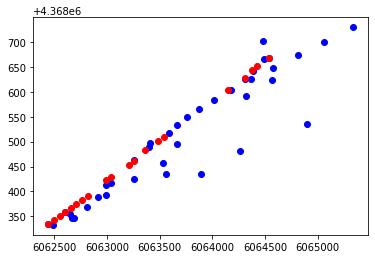

In [46]:
x_pred = df_final.iloc[:,0].values
y_pred = df_final.iloc[:,1].values


plt.plot(x_pred[np.arange(1,len(x_pred),10)],y_pred[np.arange(1,len(x_pred),10)], "bo")
plt.plot(polish_data.iloc[:,2].values ,polish_data.iloc[:,3].values, "ro")
